In [1]:
# using Pkg
# Pkg.activate(@__DIR__)

using Plots, StatsPlots
using Interpolations
using QuantEcon
using Parameters
using Optim
using Optim: minimum, minimizer
using TransformVariables
using FastChebInterp
using DataFrames, DataFramesMeta
using ConcreteStructs
using Roots
using ProgressMeter
using Statistics
using TexTables

In [2]:
# Activate the directory where your project is located
using Pkg
Pkg.activate(@__DIR__)

# Add the necessary packages to your project
Pkg.add([
    "Plots",
    "StatsPlots",
    "Interpolations",
    "QuantEcon",
    "Parameters",
    "Optim",
    "TransformVariables",
    "FastChebInterp",
    "DataFrames",
    "DataFramesMeta",
    "ConcreteStructs",
    "Roots",
    "ProgressMeter",
    "Statistics",
    "TexTables"
])

# Generate Project.toml and Manifest.toml
Pkg.instantiate()


  Activating project at `~/Desktop/programming_for_econ/exam`
   Resolving package versions...
  No Changes to `~/Desktop/programming_for_econ/exam/Project.toml`
  No Changes to `~/Desktop/programming_for_econ/exam/Manifest.toml`


In [3]:
# Some options for interpolation 
abstract type ContinuousInterp          end
struct CubicSplines <: ContinuousInterp end 
struct LinearInterp <: ContinuousInterp end 
struct ChebyInterp  <: ContinuousInterp end 
struct GridSearch
    Nl::Int
end 

interpolant(::CubicSplines, grid, V) = cubic_spline_interpolation(grid, V)
interpolant(::LinearInterp, grid, V) = linear_interpolation(grid, V)
interpolant(::ChebyInterp, grid, V)  = chebinterp(V, extrema(grid)...)
interpolant(::GridSearch, grid, V)   = throw(error(
    "You should not be constructing an interpolant if you are doing a grid search"
))

interpolant (generic function with 4 methods)

# Section B

## Question 1

In [4]:
@with_kw struct BewleyParams{T}
    β::Float64  = 0.98  
        # these type annotations (::Float64) are needed when defining a new
        # struct Julia's compiler needs to know how to lay this new object out
        # in memory
    r::Float64  = 0.017   
    μ::Float64  = 0.0   
    ρ::Float64  = 0.945
    σϵ::Float64 = 0.017 
    σ::Float64  = 2.0
    B_::Float64 = -1.0
    B::Float64  = 1.0
    Nb::Int     = 100
    Ny::Int     = 21
    θ::Float64  = 0.282
    y_s::Float64 = 0.95
    interp_mode::T = CubicSplines()
        # Here, we've annotated the type as ::T (which also shows up in the type
        # definition: BewleyParams{T}). This means that T is a type parameter --
        # it can take any value that we want
end
Base.broadcastable(p::BewleyParams) = Ref(p) # makes broadcasting work properly

# Test to see if it makes a difference, either could work
# u(p, c) = (@unpack σ = p;  c^(1-σ)/(1-σ))
function u(p, c)
    @unpack σ = p
    c < 1e-8 && return u(p, 1e-8) - 100 * (c - 1e-8)^2
    return c^(1-σ)/(1-σ) 
end


q(p) = (@unpack r = p; 1/(1+r))

function setup(p::BewleyParams, interp_mode::ContinuousInterp)
    @unpack Nb, Ny, ρ, σϵ, μ = p 
    bgrid = LinRange(-1, 1, Nb)
    # Discretize income grid
    mc    = rouwenhorst(Ny, ρ, σϵ, μ)
    ygrid = mc.state_values 
    P     = mc.p'

    # Setup guesses 
    V  = zeros(Nb, Ny)
    V0 = zeros(Nb, Ny)
    EV = zeros(Nb, Ny)

    policy = (
        c = zeros(Nb, Ny),
        b = zeros(Nb, Ny)
    )

    return (; V, V0, EV, policy, bgrid, ygrid, P)
end

function solve!(p::BewleyParams, m; tol = 1e-8, maxiter = 10000)
    @unpack V, V0       = m
    @unpack interp_mode = p
    iter = 0 
    errors = []
    while true
        iter += 1 
        update_bellman!(p, m)

        err = maximum(abs.(V - V0))
        push!(errors, err)
        err < tol       && break
        iter >= maxiter && break

        V0 .= V
        yield()
    end

    return (; V, iter, errors)
end


function update_bellman!(p::BewleyParams, m)
    @unpack EV, P, V0, V, policy, bgrid, ygrid = m
    @unpack interp_mode = p
    # Calculate expectations 
    EV .= V0 * P
    EV̂ = interpolant(interp_mode, (bgrid, ygrid), EV) 

    Threads.@threads for zy in eachindex(ygrid)
        # Interpolate along each income slice of the grid 

        # Solve the inner problem for each point on the asset grid
        for zb in eachindex(bgrid)
            @unpack v′, c, b = solve_inner(p, m, EV̂, zb, zy)
            V[zb, zy]           = v′
            policy.c[zb, zy]    = c
            policy.b[zb, zy]    = b
        end
    end
    return
end

function solve_inner(p::BewleyParams, m, EV, zb, zy)
    @unpack bgrid, ygrid = m
    @unpack β, r, B_ = p
    B = bgrid[zb]
    y = exp(ygrid[zy])
    z = y + B

    obj(B′) = begin
        c = z - q(p)*B′
        if c < 1e-8
            return -Inf
        end
        u(p, c) + β * EV(B′, ygrid[zy])
    end

    B_opt = B_
    max_obj = obj(B_opt)
    for i in eachindex(bgrid)
        B′ = bgrid[i]

        v′ = obj(B′)
        if v′ > max_obj
            max_obj = v′
            B_opt = B′
        end
    end

    c = z - q(p)*B_opt
    v′ = obj(B_opt)

    return (; v′, c, b = B_opt)
end

setup(p) = setup(p, p.interp_mode)



setup (generic function with 2 methods)

 29.744158 seconds (903.98 M allocations: 29.183 GiB, 6.39% gc time, 8.34% compilation time)


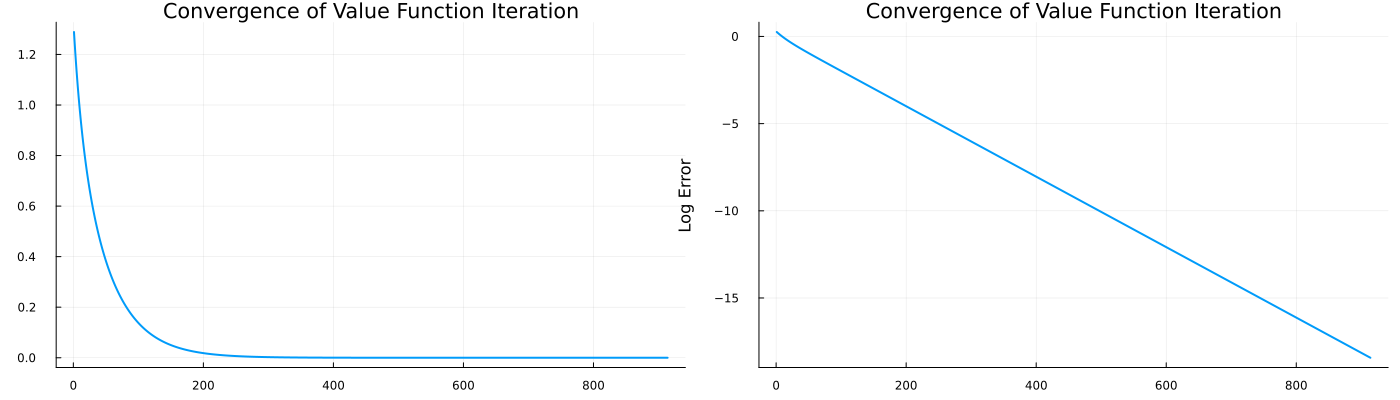

In [5]:
p = BewleyParams(B_ = -1.0, B=1.0, Nb=100, Ny=21)
m = setup(p)
@time V, iter, errors = solve!(p, m)
plt1 = plot(1:iter, errors, xlabel = "Iteration", ylabel = "Error", lw = 2, legend = false, title = "Convergence of Value Function Iteration")
plt2 = plot(1:iter, log.(errors), xlabel = "Iteration", ylabel = "Log Error", lw = 2, legend = false, title = "Convergence of Value Function Iteration")
plot(plt1, plt2, layout = (1, 2), size = (1400, 400))

To indicate convergence I have decided to plot the errors against the iterations, where for iteration of the bellman curve the error is $\max \left( \left| V - V_0 \right| \right)$. Additionally next to it we then plot the log error to indicate the speed of convergence and finally we plot the last V our function gave us. Because the log error is estimated as a straight line this means that we are consistently getting better.

In [6]:
function simulated(p::BewleyParams, m; N = 1, T = 100_000)
    @unpack bgrid, ygrid, policy, P = m
    # mc = rouwenhorst(p.Ny, p.ρ, p.σϵ)
    b  = ones(N) * mean(extrema(bgrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    # To produce them all at once
    # y = reshape(QuantEcon.simulate(m.mc, N * T), N, T)

    â = LinearInterpolation((bgrid, ygrid), policy.b)
    ĉ = LinearInterpolation((bgrid, ygrid), policy.c)

    b_list = []
    y_list = []
    for t in 1:T
        Threads.@threads for i in 1:N
            # Step assets forward 
            b′   = â(b[i], y[i])
            push!(b_list, b′)
            b[i] = b′
            
            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, y[i]) 
            yi′  = @views searchsortedfirst(Pc[:, yi], z)  
            y[i] = ygrid[yi′]
            push!(y_list, y[i])
        end
    end

    return (; b_list, b, y, y_list, c = ĉ.(b, y))
end

simulated (generic function with 1 method)

We plot for 100,000 years and only use 1 agent in the model as it is representing the representative agent who makes all decisions about consumption and debt insurance.

In [7]:
b_list, b, y, y_list, c = simulated(p, m) 
average_bond_holding = b_list[1_001:100_000]
adjusted_y = y_list[1_001:100_000]
average_bond_holding_gdp = [average_bond_holding[i] / exp.(adjusted_y[i]) for i in length(adjusted_y)] 
println("Average bond holding: ", round(mean(average_bond_holding); digits=3))
println("Average bond holding as a share of GDP: ", round(mean(average_bond_holding); digits=3))


Average bond holding: -0.898
Average bond holding as a share of GDP: -0.898


Intersetingly the average bond holding in absolute terms as well as a share of GDP is the same, one reason for this may be because the representative agent does not derive utility directly from wealth or consumption. Instead, they have a fixed utility function based only on current consumption levels. Therefore, there may not be any wealth effects influencing the saving behaviour. As a result, the average bond holdings and the average bond holding as a share of GDP will be the same because they are solely determined by the parameters of the model and the income process, which is an AR(1) process.

## Question 2

If a country chooses to default on its debt then it will never be able to borrow or save again, therefore to model this we have from that point onwards we have $c = y$ and $$v(B,y)=\max_{B',c} u(c)+\beta [\mathbb{E}v(B', y')|y], \text{ now becomes}$$

$$v(y)=\max_{c} u(c)+\beta [\mathbb{E}v(y')|y].$$
However for implementation we will require $B'$ to be 0 instead.

In [8]:
@with_kw struct Params{T}
    β::Float64  = 0.98  
        # these type annotations (::Float64) are needed when defining a new
        # struct Julia's compiler needs to know how to lay this new object out
        # in memory
    r::Float64  = 0.017   
    μ::Float64  = 0.0   
    ρ::Float64  = 0.945
    σϵ::Float64 = 0.017 
    σ::Float64  = 2.0
    B_::Float64 = -1.0
    B::Float64  = 1.0
    Nb::Int     = 100
    Ny::Int     = 21
    θ::Float64  = 0.282
    y_s::Float64 = 0.95
    interp_mode::T = CubicSplines()
        # Here, we've annotated the type as ::T (which also shows up in the type
        # definition: BewleyParams{T}). This means that T is a type parameter --
        # it can take any value that we want
end
Base.broadcastable(p::Params) = Ref(p) # makes broadcasting work properly

# Test to see if it makes a difference, either could work
# u(p, c) = (@unpack σ = p;  c^(1-σ)/(1-σ))
function u(p, c)
    @unpack σ = p
    c < 1e-8 && return u(p, 1e-8) - 100 * (c - 1e-8)^2
    return c^(1-σ)/(1-σ) 
end


q(p) = (@unpack r = p; 1/(1+r))

function setup(p::Params, interp_mode::ContinuousInterp)
    @unpack Nb, Ny, ρ, σϵ, μ, B_, B = p 
    bgrid = LinRange(B_, B, Nb)
    if !(0 in bgrid)
        bgrid = sort([bgrid; 0])  # Create a new sorted LinRange with 0 included
    end
    Nb = length(bgrid)
    
    # Discretize income grid
    mc    = rouwenhorst(Ny, ρ, σϵ, μ)
    ygrid = mc.state_values 
    P     = mc.p'

    # Setup guesses 
    V  = zeros(Nb, Ny)
    V0 = zeros(Nb, Ny)
    V_autarky = zeros(Nb, Ny)
    EV = zeros(Nb, Ny)

    policy = (
        c = zeros(Nb, Ny),
        b = zeros(Nb, Ny)
    )

    return (; V, V0, EV, policy, bgrid, ygrid, P, V_autarky)
end

function solve!(p::Params, m; tol = 1e-8, maxiter = 10000)
    @unpack V, V0, V_autarky       = m
    @unpack interp_mode = p
    iter = 0 
    errors = []
    while true
        iter += 1 
        update_bellman!(p, m)

        err = maximum(abs.(V - V0))
        push!(errors, err)
        err < tol       && break
        iter >= maxiter && break

        V0 .= V
        yield()
    end

    return (; V, iter, errors, V_autarky)
end


function update_bellman!(p::Params, m)
    @unpack EV, P, V0, V, V_autarky, policy, bgrid, ygrid = m
    @unpack interp_mode = p
    # Calculate expectations 
    bgrid_vec = LinRange(first(bgrid), last(bgrid), length(bgrid))
    ygrid_vec = LinRange(first(ygrid), last(ygrid), length(ygrid))
    EV .= V0 * P
    EV̂ = interpolant(interp_mode, (bgrid_vec, ygrid_vec), EV)

  
    # EV̂ = interpolant(interp_mode, (bgrid, ygrid), EV) 

    Threads.@threads for zy in eachindex(ygrid)
        # Interpolate along each income slice of the grid 

        # Solve the inner problem for each point on the asset grid
        for zb in eachindex(bgrid)
            @unpack v′, c, b, v_autarky = solve_inner(p, m, EV̂, zb, zy)
            V_autarky[zb, zy]    = v_autarky
            V[zb, zy]           = v′
            policy.c[zb, zy]    = c
            policy.b[zb, zy]    = b

        end
    end
    return
end

function solve_inner(p::Params, m, EV, zb, zy)
    @unpack bgrid, ygrid = m
    @unpack β, r, B_ = p
    b = bgrid[zb]
    y = exp(ygrid[zy])
    z = y + b

    obj(B′) = begin
        c = z - q(p)*B′
        if B′ < B_
            return -Inf
        end
        if c < 1e-8
            return -Inf
        end
        u(p, c) + β * EV(B′, ygrid[zy])
    end

    B_opt = B_
    max_obj = obj(B_opt)
    for i in eachindex(bgrid)
        B′ = bgrid[i]

        v′ = obj(B′)
        if v′ > max_obj
            max_obj = v′
            B_opt = B′
        end
    end

    c = z - q(p)*B_opt
    v′ = obj(B_opt)
    v_autarky = u(p, c) + β * EV(0, ygrid[zy])
    return (; v′, c, b = B_opt, v_autarky)
end

setup(p) = setup(p, p.interp_mode)

setup (generic function with 3 methods)

In [9]:
p = Params(B_=-3)
m = setup(p)
@time V, iter, errors, V_autarky = solve!(p, m)

 24.931230 seconds (804.95 M allocations: 25.326 GiB, 7.15% gc time, 1.59% compilation time)


(V = [-56.13627327714196 -55.71918046109631 … -48.719082816842864 -48.36309588256129; -56.066757599795906 -55.65294431168764 … -48.67556907670632 -48.32082541030748; … ; -50.70634138379355 -50.406901877757676 … -45.53046120985866 -45.286148555903004; -50.6708532294313 -50.37248039534702 … -45.5100014640077 -45.26642436603403], iter = 914, errors = Any[1.3469015509485103, 1.3023039616167722, 1.2601176050298308, 1.2201602990194003, 1.1822548213693453, 1.146243626765492, 1.1119830452096187, 1.0793428383861237, 1.0482060758436411, 1.0184747156248797  …  1.1905719077276444e-8, 1.1667594890241162e-8, 1.1434252655817545e-8, 1.1205571581740514e-8, 1.0981452192027064e-8, 1.0761830537830974e-8, 1.0546592932314525e-8, 1.0335661215776781e-8, 1.0128950123089453e-8, 9.926381494551606e-9], V_autarky = [-51.78597563875499 -51.446121011649744 … -46.26261753904206 -45.98736686699953; -51.71645996140894 -51.37988486224108 … -46.261860465753045 -45.98665421098204; … ; -51.394179713559254 -51.0706054754206

[ Info: Saved animation to /home/reuben/Desktop/programming_for_econ/exam/animation.gif


Plots.AnimatedGif("/home/reuben/Desktop/programming_for_econ/exam/animation.gif")
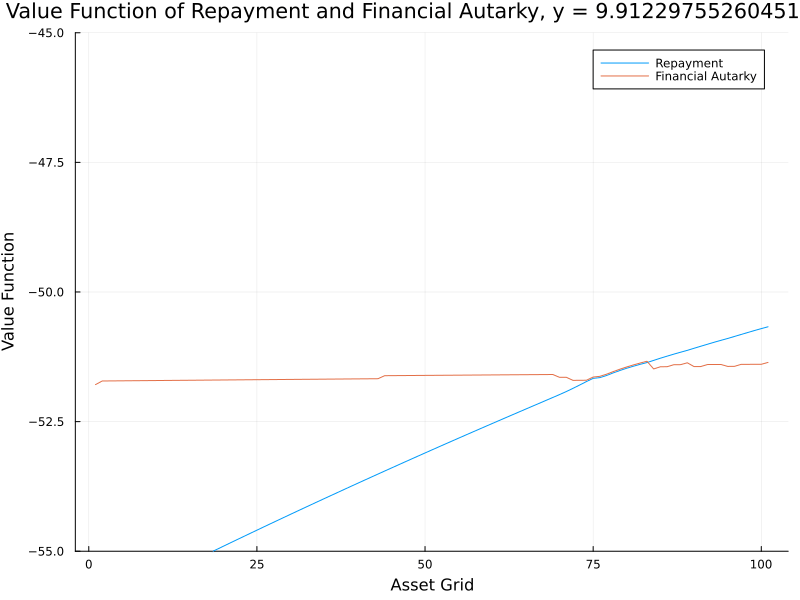

In [10]:
gr()

# Initialize an empty array to store plots
plots = []

# Loop over the values of i and create plots
for i in 1:21
    plt = plot(V[:, i], label="Repayment", xlabel="Asset Grid", ylabel="Value Function", title="Value Function of Repayment and Financial Autarky, y = $(exp(V[i, end]))")
    plot!(V_autarky[:, i], label="Financial Autarky", size=(800, 600), ylims=(-55, -45))
    push!(plots, plt)
end

# Create an animation that smoothly transitions between each plot
anim = @animate for i in 1:length(plots)
    plot(plots[i])  # Display each plot
end

# Display the animation
gif(anim, "animation.gif", fps = 3)


From this animation we can see that as the income level rises so does both the value of repayment and the value financial autarky. And the point they intersect looks to be around the same index on the asset grid which is interesting and not necessarily what I would have expected from the code.

In [11]:
rows = size(V, 1)  # Getting the number of rows
cols = size(V, 2)  # Getting the number of columns
count_v_autarky_greater = 0
for i in 1:rows
    for j in 1:cols
        if V[i, j] < V_autarky[i, j]
            count_v_autarky_greater += 1
        end
    end
end
println("The share of time in the simulated sample where the value of autarky exceeds the value of repayment is: ", count_v_autarky_greater/(rows*cols))



The share of time in the simulated sample where the value of autarky exceeds the value of repayment is: 0.8217821782178217


While comparing the values of financial autarky and repayment can provide some insights, it may not be a reliable way to measure the likelihood of default for a representative agent model. The observation that the proportion of time when the value of financial autarky is greater than the value of repayment is high (0.82) suggests that, in this simplified model, the representative agent often finds it advantageous to default on their debt and maintain consumption equal to income instead.

However, relying solely on this comparison overlooks several factors that influence default likelihood in a representative agent framework. Firstly, the comparison assumes that the representative agent always prioritizes maximising current consumption over paying off debt. While this might hold true for some representative agents, others may prioritize maintaining a good credit rating, as it affects their access to credit in the future.

Moreover, this approach does not consider the representative agent's financial situation, factors like income volatility, wealth distribution, and borrowing constraints can significantly impact the representative agent's ability to repay debt and their decision to default.

Additionally, this method may be biased because it assumes a simplistic view of default behaviour and does not account for the complexities of financial decision-making for the representative agent. Economic shocks, institutional factors, and behavioral biases may influence default decisions in ways that are not captured by a simple comparison of financial autarky and repayment values.


  2.371288 seconds (85.36 M allocations: 2.751 GiB, 8.53% gc time)
  3.440167 seconds (116.87 M allocations: 3.766 GiB, 8.11% gc time)
 28.090870 seconds (928.85 M allocations: 29.931 GiB, 7.52% gc time)
  2.301254 seconds (78.52 M allocations: 2.496 GiB, 7.31% gc time)
  3.167503 seconds (107.49 M allocations: 3.417 GiB, 7.28% gc time)
 24.329407 seconds (854.33 M allocations: 27.155 GiB, 7.30% gc time)
  2.153036 seconds (74.34 M allocations: 2.340 GiB, 7.79% gc time)
  2.960638 seconds (101.77 M allocations: 3.204 GiB, 7.05% gc time)
 22.821438 seconds (808.87 M allocations: 25.461 GiB, 7.21% gc time)


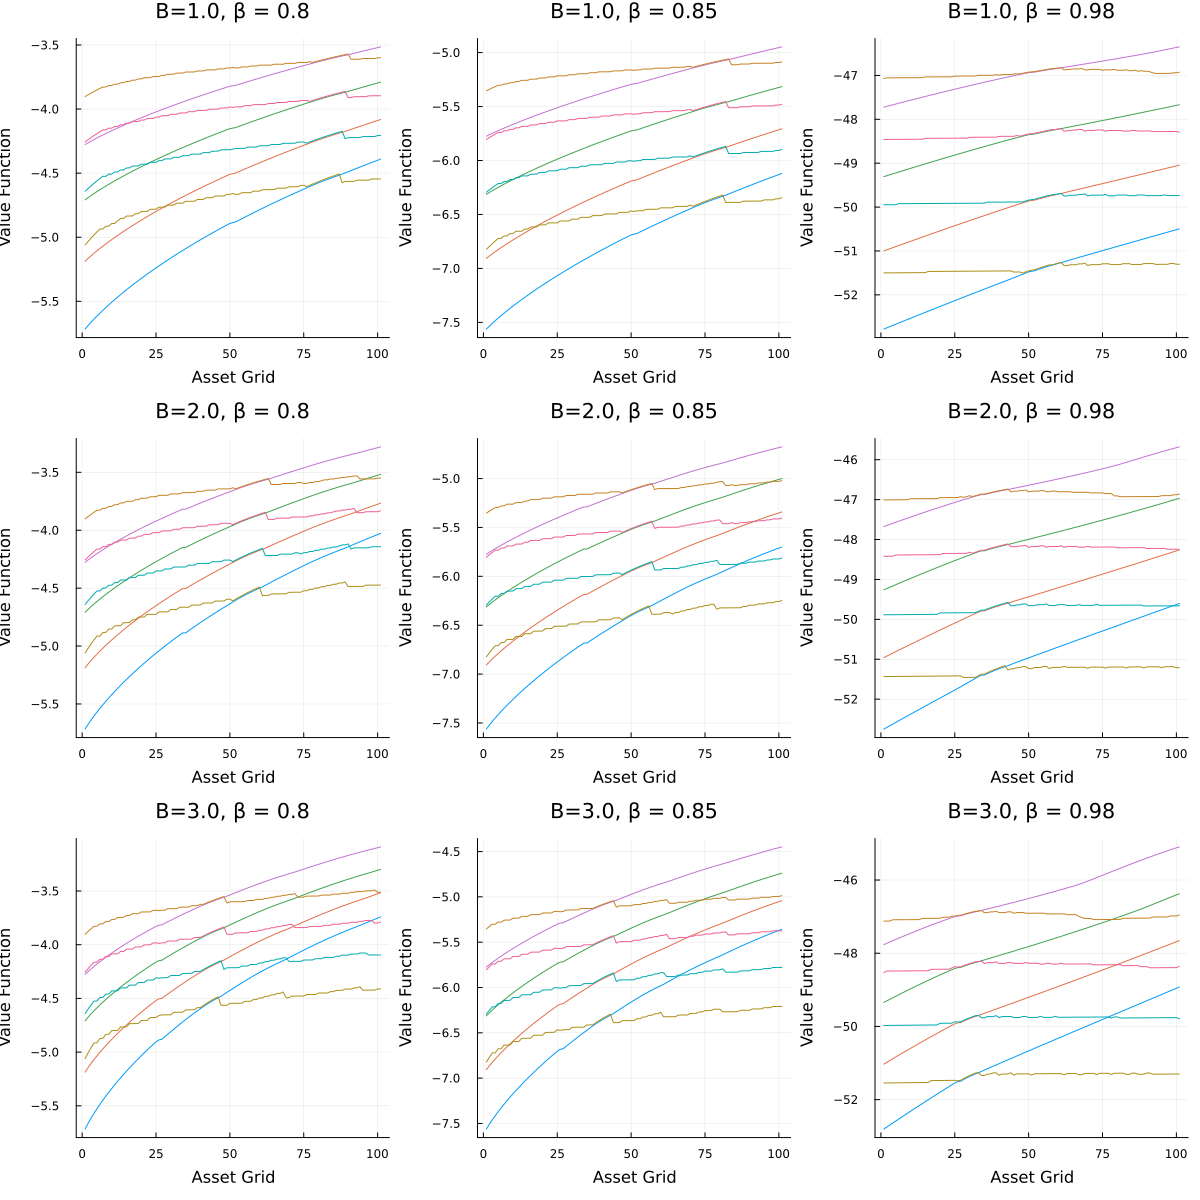

In [12]:
# Potentially interesting to see how the value function changes with different parameters

B_vals = [1.0, 2.0, 3.0]
β_vals = [0.8, 0.85, 0.98]

plts = []

for B in B_vals
    for β in β_vals
            p = Params(B=B, β=β)
            m = setup(p)
            @time V, iter, errors, V_autarky = solve!(p, m)
            
            yvals = collect(1:4) .* div(p.Ny, 4)
            plt = plot(V[:, yvals], xlabel = "Asset Grid", ylabel = "Value Function",title  = "B=$B, β = $β")
            plot!(V_autarky[:, yvals], size = (800, 600), legend = false)
            push!(plts, plt)
    end
end
plot(plts..., size = (1200, 1200))

From this above plot which explores the effects of the upper limit on the asset grid (B) and $\beta$ for representative values of $y$. We can see that as the upper limit on the asset grid increases the asset index where the value of autarky being greater than value of repayment shifting to the left. Additionally, as $\beta$ increases the asset index where the value of autarky being greater than value of repayment shifting to the left.

## Question 3

In [13]:
p = Params(B_=-3, B=1, Nb=200)
m = setup(p)
@time V, iter, errors, V_autarky = solve!(p, m)

 87.632311 seconds (3.10 G allocations: 97.454 GiB, 7.89% gc time)


(V = [-56.42004525192105 -56.01308665242199 … -49.32887756291066 -48.976771249883626; -56.38454126375577 -55.97927856352998 … -49.308553330665326 -48.95690348894023; … ; -51.42177482848759 -51.12576515759008 … -46.143559418916055 -45.89234897072397; -51.40230219049913 -51.10619744602659 … -46.13169256984918 -45.88061560532335], iter = 915, errors = Any[1.3469015509485103, 1.3023039616167722, 1.260117605029829, 1.2201528438385325, 1.1822380616532708, 1.1462184608461605, 1.1119533039263345, 1.0793150809198995, 1.0481878393115043, 1.0184659801088571  …  1.192006493511144e-8, 1.168167074183657e-8, 1.1448030079463933e-8, 1.1219078999147314e-8, 1.0994689603194274e-8, 1.0774790837331238e-8, 1.0559304541857273e-8, 1.0348117029934656e-8, 1.0141143036435096e-8, 9.938325717939733e-9], V_autarky = [-52.56217998631212 -52.23496280631001 … -46.89403816884168 -46.61428004006811; -52.526675998146835 -52.201154717418 … -46.89369190949412 -46.61395329494981; … ; -52.20870478720171 -51.89641323278023 … -

In [14]:
# Trying to work out the probability_of_default for each point in the state space
# Current most correct implementation, will use this for the rest of the question unless i can think of a more appropriate way to do it, need to decide between `10,000 or 100,000`
function probability_of_default(p::Params, m, V)
    @unpack EV, V0, bgrid, ygrid, policy, P = m
    @unpack interp_mode, β,  = p
    â = LinearInterpolation((bgrid, ygrid), policy.b)
    ĉ = LinearInterpolation((bgrid, ygrid), policy.c)
    rows = size(V, 1)  # Getting the number of rows
    cols = size(V, 2)  # Getting the number of columns
    default = zeros(rows, cols)
    EV .= V0 * P
    bgrid_vec = LinRange(first(bgrid), last(bgrid), length(bgrid))
    ygrid_vec = LinRange(first(ygrid), last(ygrid), length(ygrid))
    
    EV̂ = interpolant(interp_mode, (bgrid_vec, ygrid_vec), EV)

    for row in 1:rows
        for col in 1:cols

            for i in 1:10_000
                B = V[row]
                y = V[col]
                b = â(bgrid[row], ygrid[col])

                z = rand()
                yi = searchsortedfirst(ygrid, y)
                yi′ = searchsortedfirst(cumsum(P, dims=1)[:, yi], z)
                y = ygrid[yi′]
                V_autarky = u(p, z) + β * EV̂(0, ygrid[yi′])

                if V_autarky > V[row, col]
                    default[row, col] += 1
                end
            end
            default[row, col] = default[row, col] / 10_000
        end
    end
    return default
end

# p = Params(B_=-3, B=1, Nb=200)
# m = setup(p)
# @time V, iter, errors, V_autarky = solve!(p, m)

default_matrix = probability_of_default(p, m, V)

201×21 Matrix{Float64}:
 0.8125  0.7939  0.7729  0.7532  0.724   …  0.0003  0.0  0.0  0.0  0.0  0.0
 0.8048  0.7951  0.7784  0.7468  0.7214     0.0002  0.0  0.0  0.0  0.0  0.0
 0.8121  0.7904  0.7681  0.7487  0.721      0.0     0.0  0.0  0.0  0.0  0.0
 0.8044  0.7779  0.7643  0.7385  0.7106     0.0     0.0  0.0  0.0  0.0  0.0
 0.8006  0.7903  0.7655  0.7488  0.7174     0.0     0.0  0.0  0.0  0.0  0.0
 0.8034  0.7878  0.7648  0.74    0.7129  …  0.0     0.0  0.0  0.0  0.0  0.0
 0.8031  0.7878  0.7702  0.7308  0.7066     0.0     0.0  0.0  0.0  0.0  0.0
 0.7999  0.7843  0.7625  0.7373  0.7087     0.0     0.0  0.0  0.0  0.0  0.0
 0.7987  0.7804  0.7676  0.7367  0.7083     0.0     0.0  0.0  0.0  0.0  0.0
 0.7958  0.7844  0.7477  0.7316  0.7027     0.0     0.0  0.0  0.0  0.0  0.0
 0.7908  0.7738  0.755   0.7355  0.6899  …  0.0     0.0  0.0  0.0  0.0  0.0
 0.7937  0.7729  0.7475  0.7225  0.6976     0.0     0.0  0.0  0.0  0.0  0.0
 0.7908  0.7697  0.7503  0.7333  0.6926     0.0     0.0  0.0  0.

To work out the probability of default at each point of the state space we simulate from each point on the matrix, where it moves to and whether or not the value of autarky is greater than the value of repayment. We then visualise the probability distribution of default in a heat map, which shows that for low values of the asset grid and income implies a higher chance of default which is what we would expect.

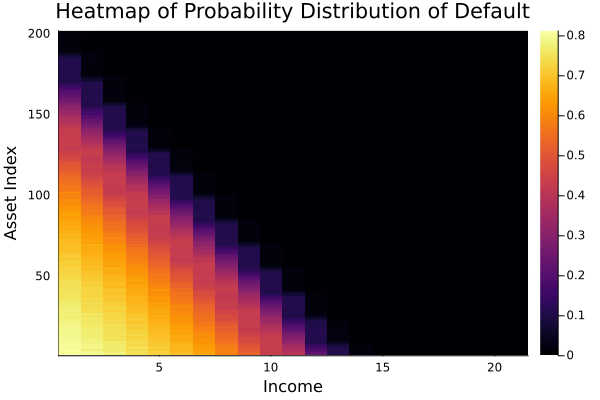

In [15]:
heatmap(default_matrix, c=:inferno, xlabel="Income", ylabel="Asset Index", title="Heatmap of Probability Distribution of Default")

In [16]:

@kwdef struct New_Parameters{T}
    β::Float64  = 0.98  
        # these type annotations (::Float64) are needed when defining a new
        # struct Julia's compiler needs to know how to lay this new object out
        # in memory
    r::Float64  = 0.017   
    μ::Float64  = 0.0   
    ρ::Float64  = 0.945
    σϵ::Float64 = 0.017 
    σ::Float64  = 2.0
    B_::Float64 = -1.0
    Nb::Int     = 200
    Ny::Int     = 21
    θ::Float64  = 0.282
    y_s::Float64 = 0.95
    interp_mode::T = CubicSplines()
        # Here, we've annotated the type as ::T (which also shows up in the type
        # definition: BewleyParams{T}). This means that T is a type parameter --
        # it can take any value that we want
end
Base.broadcastable(p::New_Parameters) = Ref(p) # makes broadcasting work properly

u(p, c) = (@unpack σ = p;  c^(1-σ)/(1-σ))

function q(p, B′, y, )
    @unpack r = p

    return (1 - default_matrix[B′, y])/(1+r)
end


function setup(p::New_Parameters, interp_mode::ContinuousInterp)
    @unpack Nb, Ny, ρ, σϵ, μ = p 
    bgrid = LinRange(-3.0, 1.0, Nb)
    # Check if 0 is in the LinRange
    if !(0 in bgrid)
        bgrid = sort([bgrid; 0])  # Create a new sorted LinRange with 0 included
    end
    Nb = length(bgrid)
    # Discretize income grid
    mc    = rouwenhorst(Ny, ρ, σϵ, μ)
    ygrid = mc.state_values 
    P     = mc.p'

    # Setup guesses 
    V  = zeros(Nb, Ny)
    V0 = zeros(Nb, Ny)
    EV = zeros(Nb, Ny)
    V_A = zeros(Nb, Ny)
    V_R = zeros(Nb, Ny)

    policy = (
        c = zeros(Nb, Ny),
        b = zeros(Nb, Ny)
    )

    return (; V, V0, EV, V_A, V_R, policy, bgrid, ygrid, P)
end

function solve!(p::New_Parameters, m; tol = 1e-8, maxiter = 10000)
    @unpack V, V0, V_A, V_R       = m
    @unpack interp_mode = p
    iter = 0 
    errors = []
    while true
        iter += 1 
        update_bellman!(p, m)

        #println(V)
        err = maximum(abs.(V - V0))
        push!(errors, err)
        err < tol       && break
        iter >= maxiter && break

        V0 .= V
        yield()
    end

    return (; V, iter, errors, V_A, V_R)
end


function update_bellman!(p::New_Parameters, m)
    @unpack EV, P, V0, V, V_A, V_R, policy, bgrid, ygrid = m
    @unpack interp_mode = p
    # Calculate expectations 
    EV .= V0 * P
    bgrid_vec = LinRange(first(bgrid), last(bgrid), length(bgrid))
    ygrid_vec = LinRange(first(ygrid), last(ygrid), length(ygrid))
    
    EV̂ = interpolant(interp_mode, (bgrid_vec, ygrid_vec), EV)


    V_A .= V_A * P
    V_Â = interpolant(interp_mode, (bgrid_vec, ygrid_vec), V_A) 
    Threads.@threads for zy in eachindex(ygrid)
        # Interpolate along each income slice of the grid 

        # Solve the inner problem for each point on the asset grid
        for zb in eachindex(bgrid)
            @unpack answer       = solve_inner_autarky(p, m, EV̂, V_Â, zb, zy)
            V_A[zb, zy]           = answer


            @unpack v′, c, b = solve_inner_repayment(p, m, EV̂, zb, zy)
            V_R[zb, zy]           = v′


            V[zb, zy]           = max(V_A[zb, zy], V_R[zb, zy])
            policy.c[zb, zy]    = c
            policy.b[zb, zy]    = b       
 
        end
    end
    return 
end

function solve_inner_autarky(p::New_Parameters, m, EV, VA, zb, zy)
    @unpack bgrid, ygrid = m
    @unpack β, r, B_, θ, y_s = p

    B = bgrid[zb]
    y = exp(ygrid[zy])


    h = min(y, y_s*y)


    answer = u(p, h) + β *(θ * EV(0, ygrid[zy]) + (1-θ) * VA(0, ygrid[zy]))


    return (;answer)
end


function solve_inner_repayment(p::New_Parameters, m, EV, zb, zy)
    @unpack bgrid, ygrid = m
    @unpack β, r, B_ = p

    B = bgrid[zb]
    y = exp(ygrid[zy])
    z = y + B
    
    obj(B′) = begin

        if B′ < B_
            return -Inf
        end
        B_idx = searchsortedfirst(bgrid, B′)

        c = z - q(p, B_idx, zy)*B′

        if c < 1e-8
            return -Inf
        end

        u(p, c) + β * EV(B′, ygrid[zy])
    end

    B_opt = B_
    max_obj = obj(B_opt)

    for i in eachindex(bgrid)
        B′ = bgrid[i]

        v′ = obj(B′)
        if v′ > max_obj
            max_obj = v′
            B_opt = B′
        end
    end

    B_index = searchsortedfirst(bgrid, B_opt)
    c = z - q(p, B_index, zy)*B_opt
    
    v′ = obj(B_opt)

    return (; v′, c, b = B_opt)
end



setup(p) = setup(p, p.interp_mode)

setup (generic function with 4 methods)

In [17]:
p = New_Parameters(B_=-3.0,  Nb=200)
m = setup(p)
@time V, iter, errors, V_A, V_R = solve!(p, m)

186.624992 seconds (8.34 G allocations: 163.359 GiB, 6.52% gc time, 0.24% compilation time)


(V = [-46.811013235292656 -46.32754056762751 … -39.54661529919226 -39.309363602797845; -46.811013235292656 -46.32754056762751 … -39.54661529919226 -39.309363602797845; … ; -45.35427928696984 -44.98817542966381 … -38.67559669872273 -38.46721171370969; -45.34038227851376 -44.97339787833369 … -38.671616776854215 -38.46333251683193], iter = 905, errors = Any[1.3280871396558305, 1.285176233652848, 1.1626939244601557, 1.1134048657723765, 1.0612790143225945, 1.0275687219709058, 0.9935786328134739, 0.9612576164608342, 0.9214855231640158, 0.8809391540627018  …  1.1850829650938977e-8, 1.161381391057148e-8, 1.1381537490251503e-8, 1.1153908019423397e-8, 1.0930833127531514e-8, 1.0712220444020204e-8, 1.0497970492906461e-8, 1.0288012219916709e-8, 1.00822532544953e-8, 9.88060833151394e-9], V_A = [-46.811013235292656 -46.32754056762751 … -39.54661529919226 -39.309363602797845; -46.811013235292656 -46.32754056762751 … -39.54661529919226 -39.309363602797845; … ; -46.811013235292656 -46.32754056762751 … -

In [18]:
rows = size(V, 1)  # Getting the number of rows
cols = size(V, 2)  # Getting the number of columns
count_v_autarky_greater = 0
for i in 1:rows
    for j in 1:cols
        if V_R[i, j] < V_A[i, j]
            count_v_autarky_greater += 1
        end
    end
end
println("The share of time in the simulated sample where the value of autarky exceeds the value of repayment is: ", count_v_autarky_greater/(rows*cols))


The share of time in the simulated sample where the value of autarky exceeds the value of repayment is: 0.29329542762378585


We see that this value has signifcantly decreased from what we got earlier, and we are inclined to believe that this is a more realistic outcome.

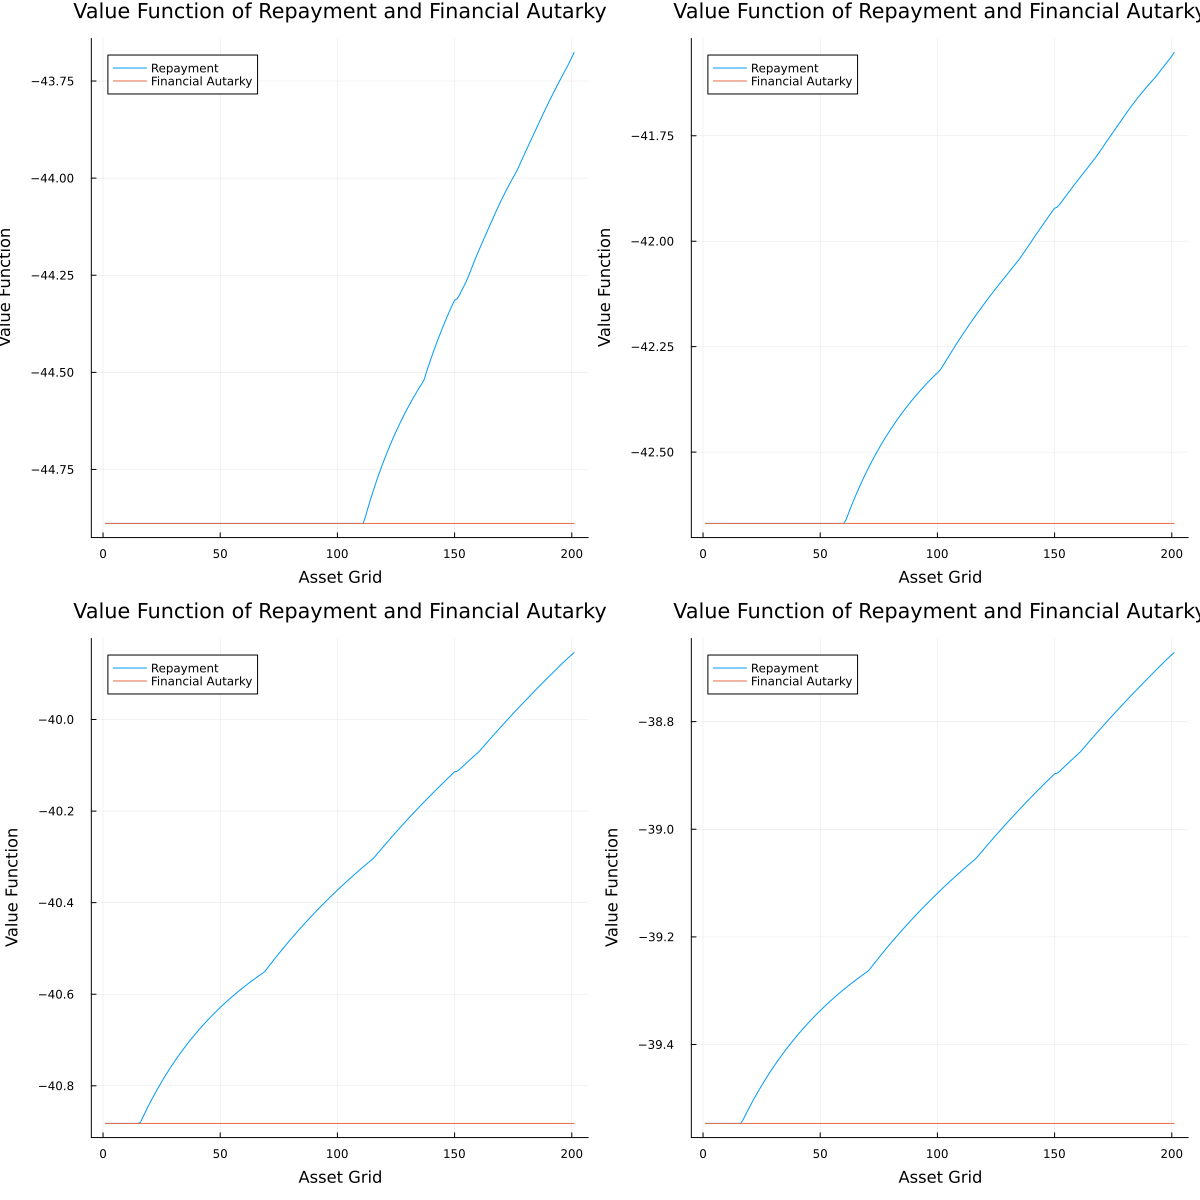

In [19]:
yvals = collect(1:4) .* div(p.Ny, 4)
plts = []
for i in 1:4
    plt = plot(V[:, yvals[i]], label = "Repayment", xlabel = "Asset Grid", ylabel = "Value Function", title = "Value Function of Repayment and Financial Autarky")
    plot!(V_A[:, yvals[i]], label = "Financial Autarky", size = (800, 600))
    push!(plts, plt)
end
plot(plts..., size = (1200, 1200))

We see that for representative values for income the value of repayment is now much greater than the value of Autarky for most asset index level.

In [20]:
function simulation(p::New_Parameters, m; N = 1, T = 100_000)
    @unpack bgrid, ygrid, policy, P = m
    # mc = rouwenhorst(p.Ny, p.ρ, p.σϵ)
    b  = ones(N) * mean(extrema(bgrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    # To produce them all at once
    # y = reshape(QuantEcon.simulate(m.mc, N * T), N, T)

    â = LinearInterpolation((bgrid, ygrid), policy.b)
    ĉ = LinearInterpolation((bgrid, ygrid), policy.c)

    b_list = []
    y_list = []
    for t in 1:T
        Threads.@threads for i in 1:N
            # Step assets forward 
            b′   = â(b[i], y[i])
            push!(b_list, b′)
            b[i] = b′
            
            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, y[i]) 
            yi′  = @views searchsortedfirst(Pc[:, yi], z)  
            y[i] = ygrid[yi′]
            push!(y_list, y[i])
        end
    end

    return (; b_list, b, y, y_list, c = ĉ.(b, y))
end

simulation (generic function with 1 method)

In [21]:
b_list, b, y, y_list, c = simulation(p, m) 
average_bond_holding = b_list[1_001:100_000]
adjusted_y = y_list[1_001:100_000]
average_bond_holding_gdp = [average_bond_holding[i] / adjusted_y[i] for i in length(adjusted_y)] 
println("Average bond holding: ", round(mean(average_bond_holding); digits=3))
println("Average bond holding as a share of GDP: ", round(mean(average_bond_holding); digits=3))

Average bond holding: -2.599
Average bond holding as a share of GDP: -2.599


And now without having a lower bound on the debt limit the representative agent prefers to have a greater amount of debt than the previous limit. Additionally, here the average bond holding is the same as the average bond holding as a share of GDP.

## Question 4

Ideally if I had more time I would attempt a method such as policy function iteration however, it is already quite late. So instead I will attempt to run it while I rest and hopefully there will be an answer similar to the required probability of default of 0.75 and debt to GDP ratio of 5.95.

In [22]:
function probability_of_default(p::New_Parameters, m, V)
    @unpack EV, V0, bgrid, ygrid, policy, P = m
    @unpack interp_mode, β,  = p
    â = LinearInterpolation((bgrid, ygrid), policy.b)
    ĉ = LinearInterpolation((bgrid, ygrid), policy.c)
    rows = size(V, 1)  # Getting the number of rows
    cols = size(V, 2)  # Getting the number of columns
    default = zeros(rows, cols)
    EV .= V0 * P
    bgrid_vec = LinRange(first(bgrid), last(bgrid), length(bgrid))
    ygrid_vec = LinRange(first(ygrid), last(ygrid), length(ygrid))
    
    EV̂ = interpolant(interp_mode, (bgrid_vec, ygrid_vec), EV)

    for row in 1:rows
        for col in 1:cols

            for i in 1:10_000
                B = V[row]
                y = V[col]
                b = â(bgrid[row], ygrid[col])

                z = rand()
                yi = searchsortedfirst(ygrid, y)
                yi′ = searchsortedfirst(cumsum(P, dims=1)[:, yi], z)
                y = ygrid[yi′]
                V_autarky = u(p, z) + β * EV̂(0, ygrid[yi′])

                if V_autarky > V[row, col]
                    default[row, col] += 1
                end
            end
            default[row, col] = default[row, col] / 10_000
        end
    end
    return default
end

probability_of_default (generic function with 2 methods)

In [23]:
β_vals = LinRange(0.9, 0.98, 20)
y_s_vals = LinRange(0.8, 1.0, 20)

using DataFrames

# Initialize an empty DataFrame to store results
results_df = DataFrame(β = Float64[], y_s = Float64[], mean_bond_holding = Float64[])
plots = []

Threads.@threads for β in β_vals
    for y_s in y_s_vals
        p = New_Parameters(β=β, y_s=y_s, B_=-3.0,  Nb=200)
        m = setup(p)
        @time V, iter, errors, V_A, V_R = solve!(p, m)
        rows = size(V, 1)  # Getting the number of rows
        cols = size(V, 2)  # Getting the number of columns
        count_v_autarky_greater = 0
        for i in 1:rows
            for j in 1:cols
                if V_R[i, j] < V_A[i, j]
                    count_v_autarky_greater += 1
                end
            end
        end

        default = probability_of_default(p, m, V)
        plt = heatmap(default, c=:inferno, xlabel="X", ylabel="Y", title = "β=$(round(β; digits=2)), y_s=$(round(y_s; digits=2))")
        push!(plots, plt)

        b_list, b, y, y_list, c = simulation(p, m) 
        average_bond_holding = b_list[1_001:100_000]
        adjusted_y = y_list[1_001:100_000]
        average_bond_holding_gdp = [average_bond_holding[i] / adjusted_y[i] for i in length(adjusted_y)] 
        mean_bond_holding = round(mean(average_bond_holding); digits=2)
        
        # Store results in DataFrame
        push!(results_df, (β = β, y_s = y_s, mean_bond_holding = mean_bond_holding))  
    end
end

 37.189924 seconds (1.62 G allocations: 31.764 GiB, 6.92% gc time)
 37.294572 seconds (1.62 G allocations: 31.764 GiB, 7.19% gc time)
 38.068747 seconds (1.62 G allocations: 31.764 GiB, 7.44% gc time)
 38.534748 seconds (1.62 G allocations: 31.764 GiB, 7.57% gc time)
 43.599142 seconds (1.62 G allocations: 31.764 GiB, 6.34% gc time)
 47.758489 seconds (1.62 G allocations: 31.764 GiB, 6.02% gc time)
 48.441981 seconds (1.61 G allocations: 31.583 GiB, 6.61% gc time)
 48.998523 seconds (1.61 G allocations: 31.583 GiB, 6.90% gc time)
 54.353187 seconds (1.61 G allocations: 31.583 GiB, 7.12% gc time)
 56.927540 seconds (1.61 G allocations: 31.583 GiB, 7.20% gc time)
 58.498350 seconds (1.61 G allocations: 31.583 GiB, 7.44% gc time)
 53.619618 seconds (1.61 G allocations: 31.583 GiB, 6.18% gc time)
 53.193404 seconds (1.61 G allocations: 31.583 GiB, 5.82% gc time)
 53.630816 seconds (1.61 G allocations: 31.583 GiB, 6.43% gc time)
 57.853404 seconds (1.61 G allocations: 31.583 GiB, 6.70% gc t

LoadError: TaskFailedException

[91m    nested task error: [39mTaskFailedException
    
    [91m    nested task error: [39mInterruptException:
        Stacktrace:
         [1] [0m[1mgetindex[22m[0m[1m([22m::[0mMatrix[90m{Float64}[39m, ::[0mInt64, ::[0mInt64[0m[1m)[22m
        [90m   @[39m [90mBase[39m [90m./[39m[90m[4messentials.jl:14[24m[39m
         [2] [0m[1mq[22m[0m[1m([22m[90mp[39m::[0mNew_Parameters[90m{CubicSplines}[39m, [90mB′[39m::[0mInt64, [90my[39m::[0mInt64[0m[1m)[22m
        [90m   @[39m [35mMain[39m [90m./[39m[90m[4mIn[16]:29[24m[39m
         [3] [0m[1m(::var"#obj#31"{New_Parameters{CubicSplines}, Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Throw{Nothing}}, Int64, Float64, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Vector{Float64}})[22m[0m[1m([22m[90mB′[39m::[0mFloat64[0m[1m)[22m
        [90m   @[39m [35mMain[39m [90m./[39m[90m[4mIn[16]:152[24m[39m
         [4] [0m[1msolve_inner_repayment[22m[0m[1m([22m[90mp[39m::[0mNew_Parameters[90m{CubicSplines}[39m, [90mm[39m::[0m@NamedTuple[90m{V::Matrix{Float64}, V0::Matrix{Float64}, EV::Matrix{Float64}, V_A::Matrix{Float64}, V_R::Matrix{Float64}, policy::@NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, bgrid::Vector{Float64}, ygrid::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, P::LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}[39m, [90mEV[39m::[0mInterpolations.Extrapolation[90m{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Throw{Nothing}}[39m, [90mzb[39m::[0mInt64, [90mzy[39m::[0mInt64[0m[1m)[22m
        [90m   @[39m [35mMain[39m [90m./[39m[90m[4mIn[16]:167[24m[39m
         [5] [0m[1mmacro expansion[22m
        [90m   @[39m [90m~/.julia/packages/UnPack/EkESO/src/[39m[90m[4mUnPack.jl:100[24m[39m[90m [inlined][39m
         [6] [0m[1mmacro expansion[22m
        [90m   @[39m [90m./[39m[90m[4mIn[16]:106[24m[39m[90m [inlined][39m
         [7] [0m[1m(::var"#134#threadsfor_fun#29"{var"#134#threadsfor_fun#28#30"{New_Parameters{CubicSplines}, @NamedTuple{V::Matrix{Float64}, V0::Matrix{Float64}, EV::Matrix{Float64}, V_A::Matrix{Float64}, V_R::Matrix{Float64}, policy::@NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, bgrid::Vector{Float64}, ygrid::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, P::LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}, Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Throw{Nothing}}, Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Throw{Nothing}}, Vector{Float64}, @NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Base.OneTo{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
        [90m   @[39m [35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
         [8] [0m[1m#134#threadsfor_fun[22m
        [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
         [9] [0m[1m(::Base.Threads.var"#1#2"{var"#134#threadsfor_fun#29"{var"#134#threadsfor_fun#28#30"{New_Parameters{CubicSplines}, @NamedTuple{V::Matrix{Float64}, V0::Matrix{Float64}, EV::Matrix{Float64}, V_A::Matrix{Float64}, V_R::Matrix{Float64}, policy::@NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, bgrid::Vector{Float64}, ygrid::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, P::LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}, Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Throw{Nothing}}, Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Throw{Nothing}}, Vector{Float64}, @NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Base.OneTo{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
        [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m
    Stacktrace:
      [1] [0m[1mthreading_run[22m[0m[1m([22m[90mfun[39m::[0mvar"#134#threadsfor_fun#29"[90m{var"#134#threadsfor_fun#28#30"{New_Parameters{CubicSplines}, @NamedTuple{V::Matrix{Float64}, V0::Matrix{Float64}, EV::Matrix{Float64}, V_A::Matrix{Float64}, V_R::Matrix{Float64}, policy::@NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, bgrid::Vector{Float64}, ygrid::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, P::LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}, Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Throw{Nothing}}, Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Throw{Nothing}}, Vector{Float64}, @NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Base.OneTo{Int64}}}[39m, [90mstatic[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:172[24m[39m
      [2] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:220[24m[39m[90m [inlined][39m
      [3] [0m[1mupdate_bellman![22m[0m[1m([22m[90mp[39m::[0mNew_Parameters[90m{CubicSplines}[39m, [90mm[39m::[0m@NamedTuple[90m{V::Matrix{Float64}, V0::Matrix{Float64}, EV::Matrix{Float64}, V_A::Matrix{Float64}, V_R::Matrix{Float64}, policy::@NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, bgrid::Vector{Float64}, ygrid::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, P::LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMain[39m [90m./[39m[90m[4mIn[16]:97[24m[39m
      [4] [0m[1msolve![22m[0m[1m([22m[90mp[39m::[0mNew_Parameters[90m{CubicSplines}[39m, [90mm[39m::[0m@NamedTuple[90m{V::Matrix{Float64}, V0::Matrix{Float64}, EV::Matrix{Float64}, V_A::Matrix{Float64}, V_R::Matrix{Float64}, policy::@NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, bgrid::Vector{Float64}, ygrid::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, P::LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}[39m; [90mtol[39m::[0mFloat64, [90mmaxiter[39m::[0mInt64[0m[1m)[22m
    [90m    @[39m [35mMain[39m [90m./[39m[90m[4mIn[16]:68[24m[39m
      [5] [0m[1msolve![22m[0m[1m([22m[90mp[39m::[0mNew_Parameters[90m{CubicSplines}[39m, [90mm[39m::[0m@NamedTuple[90m{V::Matrix{Float64}, V0::Matrix{Float64}, EV::Matrix{Float64}, V_A::Matrix{Float64}, V_R::Matrix{Float64}, policy::@NamedTuple{c::Matrix{Float64}, b::Matrix{Float64}}, bgrid::Vector{Float64}, ygrid::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, P::LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMain[39m [90m./[39m[90m[4mIn[16]:61[24m[39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mtiming.jl:279[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mIn[23]:14[24m[39m[90m [inlined][39m
      [8] [0m[1m(::var"#173#threadsfor_fun#40"{var"#173#threadsfor_fun#38#41"{LinRange{Float64, Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
      [9] [0m[1m#173#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [10] [0m[1m(::Base.Threads.var"#1#2"{var"#173#threadsfor_fun#40"{var"#173#threadsfor_fun#38#41"{LinRange{Float64, Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

This code was going to take a significant amount of time to run so I stopped it early to see id there was anything to see from what it had made so far.

In [24]:
results_df

340×3 DataFrame
 Row │ β         y_s       mean_bond_holding 
     │ Float64   Float64   Float64           
─────┼───────────────────────────────────────
   1 │ 0.9       0.8                   -2.62
   2 │ 0.9       0.810526              -2.6
   3 │ 0.9       0.821053              -2.6
   4 │ 0.9       0.831579              -2.6
   5 │ 0.9       0.842105              -2.6
   6 │ 0.9       0.852632              -2.6
   7 │ 0.9       0.863158              -2.61
   8 │ 0.9       0.873684              -2.61
   9 │ 0.9       0.884211              -2.61
  10 │ 0.9       0.894737              -2.6
  11 │ 0.9       0.905263              -2.61
  ⋮  │    ⋮         ⋮              ⋮
 331 │ 0.967368  0.905263              -2.61
 332 │ 0.967368  0.915789              -2.6
 333 │ 0.967368  0.926316              -2.61
 334 │ 0.967368  0.936842              -2.61
 335 │ 0.967368  0.947368              -2.61
 336 │ 0.967368  0.957895              -2.61
 337 │ 0.967368  0.968421              -2.6
 338 │ 0.967368  0.978947              -2.61
 339 │ 0.967368  0.989474              -2.6
 340 │ 0.967368  1.0                   -2.61
                             319 rows omitted

In [25]:
max_mean_bond_holding = maximum(results_df[:, "mean_bond_holding"])
println("Maximum mean bond holding: ", max_mean_bond_holding)

Maximum mean bond holding: -2.59


From this I believe there is an error in my implementation of either the code finding the convergence or in the code finding the mean bond_holding but I did not have enough time to explore this. I would guess it was finding the mean bond holding as there is not much deviation in a large range of different $\beta$ values and $y_s$ values.